<h1 style="color: #FECB05; text-align: center;">HDBSCAN (Agrupamiento Espacial Basado en Densidad Jerárquica de Aplicaciones con Ruido)</h1>

<h2 id="section1" style="color: #007ACC;">Introducción</h2>

En nuestra sesión anterior, vimos que **DBSCAN** es una herramienta fantástica. Nos liberó de las limitaciones de los clústeres esféricos de K-Means y nos dio la capacidad de encontrar agrupaciones con formas complejas y, al mismo tiempo, identificar el ruido. Funciona de maravilla cuando los clústeres en nuestros datos tienen una densidad más o menos uniforme.

Pero, ¿qué sucede cuando la realidad de los datos es más compleja?

Imagina un conjunto de datos donde tienes un grupo de puntos muy compacto y denso, y otro grupo mucho más disperso y extendido. Este es el talón de Aquiles de DBSCAN. El problema radica en su hiperparámetro clave: **`eps`**. Este valor es un umbral de distancia **global**, lo que significa que se aplica por igual a todo el conjunto de datos.

* Si eliges un `eps` **pequeño** para capturar el clúster denso, los puntos del clúster disperso quedarán demasiado lejos unos de otros y serán incorrectamente clasificados como ruido.
* Si eliges un `eps` **grande** para poder agrupar el clúster disperso, es muy probable que termines fusionando el clúster denso con otros puntos cercanos o incluso con el otro clúster.

Es como intentar tomar una foto de un objeto muy cercano y una montaña lejana al mismo tiempo: si enfocas el objeto cercano, la montaña se verá borrosa, y si enfocas la montaña, el objeto cercano perderá todo su detalle. Con DBSCAN, estamos forzados a elegir un solo "enfoque" de densidad.

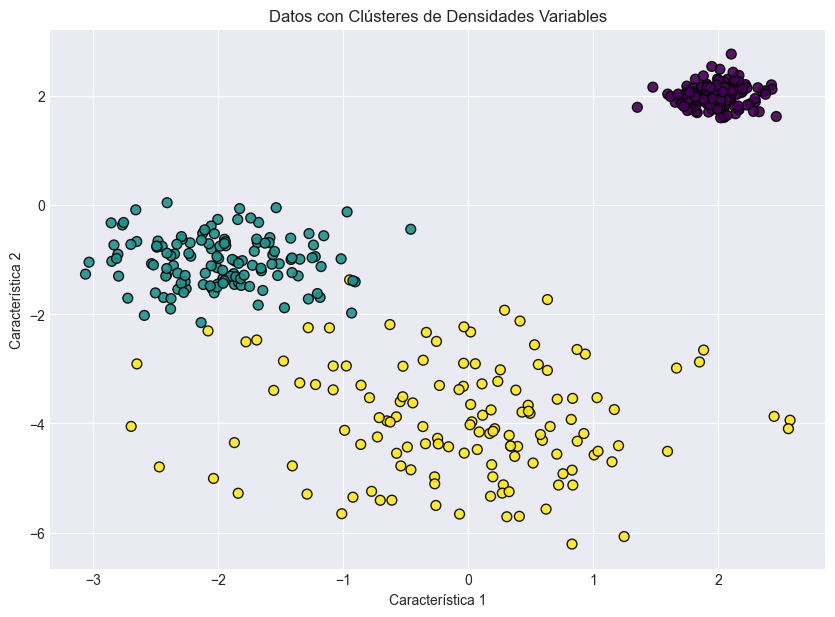

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# --- 1. Generar datos con densidades variables ---
# Usamos make_blobs para crear 3 clústeres.
# 'cluster_std' define la desviación estándar de cada clúster,
# creando uno muy denso (0.2), uno intermedio (0.5) y uno muy disperso (1.0).
X, y = make_blobs(n_samples=400,
                  centers=[[2, 2], [-2, -1], [0, -4]],
                  cluster_std=[0.2, 0.5, 1.0],
                  random_state=42)

# --- 2. Visualizar los datos generados ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(10, 7))

# Se usa 'y' para colorear los puntos según su clúster verdadero y así ver la estructura.
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', edgecolors='k', alpha=0.9)

plt.title('Datos con Clústeres de Densidades Variables')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.grid(True)
plt.show()

<h2 id="section1" style="color: #007ACC;">La Solución Jerárquica de HDBSCAN</h2>

Para resolver este dilema, necesitamos un algoritmo más inteligente y adaptable. Aquí es donde entra en juego **HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)**.

La 'H' de "jerárquico" es la clave de todo. La idea central de HDBSCAN es brillante: **en lugar de comprometernos con un único valor de `eps`, vamos a explorar todos los posibles valores de `eps` simultáneamente.**

El algoritmo transforma la idea de un clúster plano en una **jerarquía de clústeres**. Construye un árbol que muestra cómo los puntos se agrupan a diferentes escalas de distancia. Luego, en lugar de cortar este árbol a una altura específica (como hacen otros algoritmos jerárquicos), HDBSCAN busca los clústeres que son más **estables** o **persistentes** a lo largo de esta jerarquía. En otras palabras, identifica las agrupaciones que se mantienen unidas durante una amplia gama de valores de `eps`.

Esto nos brinda dos ventajas monumentales:
1.  **No necesitamos ajustar el hiperparámetro `eps`**, eliminando la parte más difícil y sensible de la configuración de DBSCAN.
2.  Puede **identificar correctamente clústeres de densidades variables** en el mismo conjunto de datos, lo que lo convierte en una herramienta mucho más robusta y versátil.

En esta sesión, descubriremos cómo HDBSCAN logra esta hazaña, explorando sus conceptos fundamentales y su aplicación práctica.

<h2 id="section1" style="color: #007ACC;">Matemática del HBSCAN</h2>

HDBSCAN es una evolución sofisticada de DBSCAN. Para lograr su flexibilidad con densidades variables, reemplaza el concepto simple de la $\epsilon$-vecindad por un enfoque jerárquico basado en una nueva forma de medir la distancia. Vamos a desglosar los cuatro pasos matemáticos clave que sigue el algoritmo.

<h3 id="section1" style="color: #007ACC;"> Transformar la Distancia (Core Distance y Mutual Reachability) </h3>

El primer paso es dejar de pensar en un radio `eps` global. En su lugar, HDBSCAN define la "densidad" localmente para cada punto.

**Definición: Core Distance ($d_{\text{core}}$)**
Para cada punto $p$, su **core distance**, denotada como $d_{\text{core},k}(p)$, es la distancia a su $k$-ésimo vecino más cercano. El valor de $k$ es el hiperparámetro que en la librería se llama `min_samples`.

$$d_{\text{core},k}(p) = \text{dist}(p, N_k(p))$$

Donde $N_k(p)$ es el $k$-ésimo vecino más cercano de $p$. Intuitivamente, un punto en una región muy densa tendrá una *core distance* pequeña, mientras que un punto en una región dispersa tendrá una *core distance* grande.

Con esta nueva medida de densidad local, HDBSCAN define una nueva métrica de distancia "suavizada" entre puntos.

**Definición: Distancia de Alcanzabilidad Mutua ($d_{\text{mreach}}$)**
La distancia de alcanzabilidad mutua entre dos puntos, $a$ y $b$, no es simplemente su distancia euclidiana. Se define como el máximo de tres valores: la *core distance* de $a$, la *core distance* de $b$, y la distancia euclidiana entre ellos.

$$d_{\text{mreach},k}(a, b) = \max\{ d_{\text{core},k}(a), d_{\text{core},k}(b), \text{dist}(a, b) \}$$

**¿Por qué esta fórmula?**
* **Dentro de un clúster denso:** Todos los puntos tendrán una *core distance* pequeña. Por lo tanto, la $d_{\text{mreach}}$ será prácticamente igual a su distancia euclidiana normal $\text{dist}(a, b)$.
* **Entre clústeres o con puntos dispersos:** Si el punto $b$ está en una región dispersa, su $d_{\text{core},k}(b)$ será grande. La $d_{\text{mreach}}(a, b)$ será "empujada hacia arriba" para ser al menos tan grande como $d_{\text{core},k}(b)$. Esto evita que los puntos dispersos se conecten a clústeres densos a distancias cortas, manteniendo los clústeres bien separados.

<h3 id="section1" style="color: #007ACC;"> Paso 2: Construir el Grafo de Conexión Mínima (MST) </h3>

Con esta nueva matriz de distancias ($d_{\text{mreach}}$), el algoritmo construye un grafo donde cada punto es un vértice y el peso de cada arista entre dos puntos es su $d_{\text{mreach}}$. A partir de este grafo, se construye un **Grafo de Conexión Mínima** (Minimum Spanning Tree, MST).

El MST es un subgrafo que conecta todos los puntos con el menor peso total posible en las aristas, sin formar ciclos. Intuitivamente, el MST representa las conexiones más fuertes y fundamentales de la estructura de los datos, según nuestra nueva métrica de distancia.

<h3 id="section1" style="color: #007ACC;"> Paso 3: Construir la Jerarquía de Clústeres </h3>
    
El MST es la base para la jerarquía. El algoritmo ordena las aristas del MST de menor a mayor peso. Luego, crea una jerarquía de clústeres fusionando puntos en orden creciente de la distancia de sus aristas. Este proceso genera un **dendrograma**, un diagrama de árbol que visualiza cómo los clústeres se fusionan a diferentes niveles de distancia.

<h3 id="section1" style="color: #007ACC;"> Paso 4: Extraer los Clústeres Estables </h3>

Aquí reside la magia de HDBSCAN. En lugar de cortar el dendrograma a una altura fija (lo que sería equivalente a elegir un `eps` global), el algoritmo lo analiza para encontrar los clústeres más **estables**.

Para ello, introduce el concepto de $\lambda$ (lambda), que es el inverso de la densidad. Un valor alto de $\lambda$ corresponde a una distancia grande ($d_{\text{mreach}}$) y baja densidad, mientras que un valor bajo corresponde a una distancia corta y alta densidad.

**Definición: Estabilidad del Clúster**
Para cada clúster que aparece en el dendrograma, el algoritmo calcula su estabilidad. Conceptualmente, la estabilidad de un clúster $C$ se calcula de la siguiente manera:

$$\text{Estabilidad}(C) = \sum_{p \in C} (\lambda_{\text{max}}(p, C) - \lambda_{\text{min}}(C))$$

* $\lambda_{\text{min}}(C)$ es el valor de $\lambda$ (distancia) al cual el clúster $C$ se formó.
* $\lambda_{\text{max}}(p, C)$ es el valor de $\lambda$ al cual el punto $p$ "abandona" el clúster $C$ para fusionarse con otro.

Un clúster es **estable** si persiste a través de un amplio rango de valores de $\lambda$ (es decir, si la diferencia entre su "nacimiento" y su "disolución" es grande).

El algoritmo de extracción recorre el árbol de arriba hacia abajo. En cada división, compara la estabilidad del clúster padre con la suma de las estabilidades de sus clústeres hijos. Si los hijos son más estables, el algoritmo continúa descendiendo. Si el padre es más estable, se selecciona como un clúster final y no se exploran sus descendientes.

Los puntos que no pertenecen a ninguno de los clústeres estables seleccionados son, finalmente, etiquetados como **ruido**.

/Users/juanfelipe/Proyectos/UPTC/Economía/Clases/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juanfelipe/Proyectos/UPTC/Economía/Clases/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


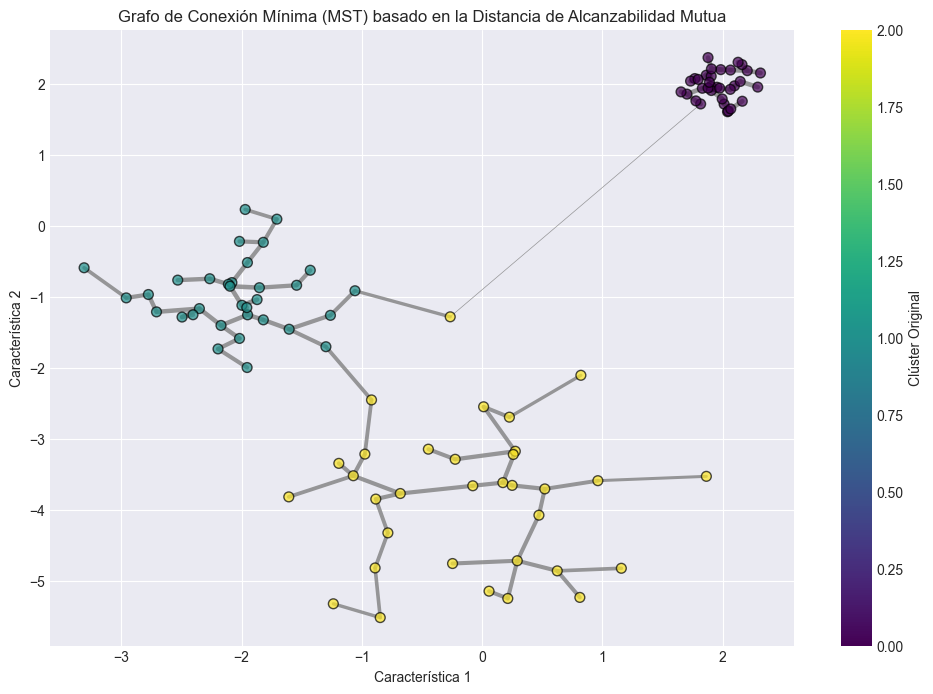

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100,
                  centers=[[2, 2], [-2, -1], [0, -4]],
                  cluster_std=[0.2, 0.5, 1.0],
                  random_state=42)

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, prediction_data=True, gen_min_span_tree=True)

hdbscan_model.fit(X)
mst = hdbscan_model.minimum_spanning_tree_.to_pandas()

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', edgecolors='k', alpha=0.7, zorder=2)

for index, row in mst.iterrows():
    p1_idx, p2_idx = int(row['from']), int(row['to'])
    p1, p2 = X[p1_idx], X[p2_idx]
    weight = row['distance']
    
    linewidth = 3 * (1 - weight / mst['distance'].max()) + 0.5
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 
             linewidth=linewidth, 
             color='gray', 
             alpha=0.8,
             zorder=1)

plt.title('Grafo de Conexión Mínima (MST) basado en la Distancia de Alcanzabilidad Mutua')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=y.min(), vmax=y.max())),
             ax=plt.gca(), label='Clúster Original')
plt.show()

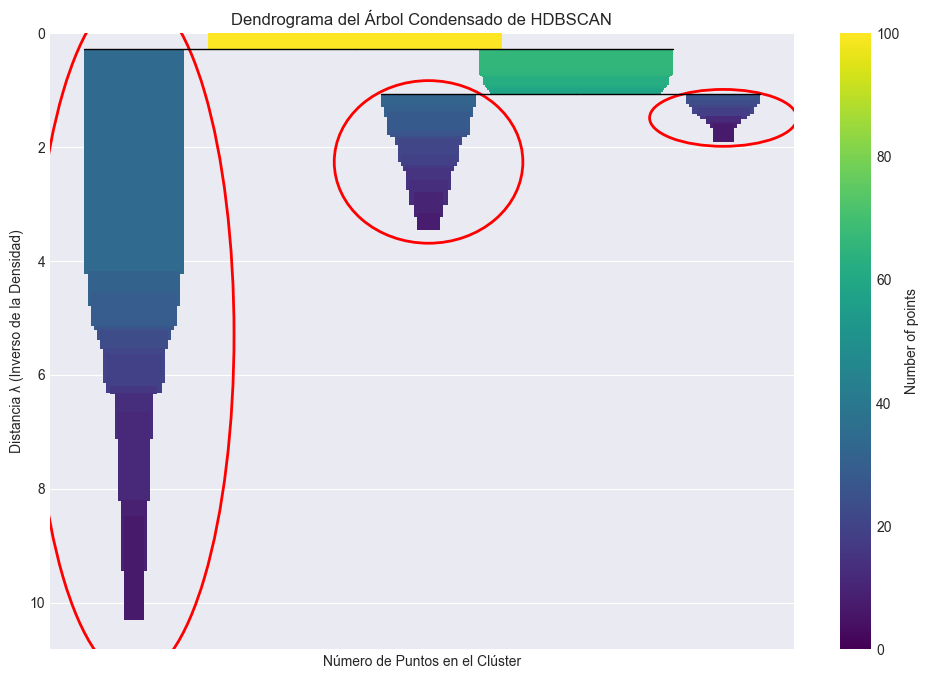

In [12]:
plt.figure(figsize=(12, 8))
plt.title('Dendrograma del Árbol Condensado de HDBSCAN')

# El método .plot() se encarga de toda la visualización
hdbscan_model.condensed_tree_.plot(select_clusters=True)

plt.xlabel('Número de Puntos en el Clúster')
plt.ylabel('Distancia λ (Inverso de la Densidad)')
plt.show()

Este gráfico puede parecer complejo al principio, pero es increíblemente informativo:

1.  **Eje Y (Distancia $\\lambda$):** Este es el eje más importante. Representa la **distancia de alcanzabilidad mutua** ($d\_{\\text{mreach}}$).

      * **Abajo (λ bajo):** Corresponde a regiones de **alta densidad** (distancias cortas).
      * **Arriba (λ alto):** Corresponde a regiones de **baja densidad** (distancias grandes).

2.  **Eje X:** Representa los puntos de datos, agrupados en clústeres.

3.  **Líneas Verticales:** Cada línea vertical representa un clúster. La **longitud de la línea** es crucial: simboliza la **estabilidad** del clúster. Un clúster con una línea vertical muy larga es uno que "persiste" o se mantiene unido a través de un amplio rango de densidades (valores de $\\lambda$).

4.  **Colores:**

      * Las **ramas de colores sólidos** son los clústeres que HDBSCAN ha seleccionado como los más estables y que forman el resultado final del clustering.
      * Las **ramas grises o desvanecidas** son clústeres que el algoritmo consideró "inestables" y, por lo tanto, descartó. O bien se fusionaron demasiado rápido con otros grupos o se descompusieron en subgrupos más estables.

En esencia, el algoritmo de extracción de HDBSCAN recorre este árbol y **selecciona las ramas de colores que tienen la mayor "área" o "estabilidad"**, podando las que son menos significativas. Esta visualización te permite ver exactamente por qué se eligieron ciertos grupos y cómo se relacionan jerárquicamente.

<h2 id="section1" style="color: #007ACC;">DBSCAN vs HDBSCAN</h2>

| Característica | DBSCAN | HDBSCAN |
| :--- | :--- | :--- |
| **Manejo de la Densidad** 🧠 | Utiliza un umbral de densidad **global y fijo** (`eps`). | Se adapta a la densidad **local** de cada región. |
| **Hiperparámetros Clave** | `eps` (radio) y `min_samples`. La elección de `eps` es crítica y a menudo difícil. | `min_cluster_size` y `min_samples`. **Elimina la necesidad de elegir `eps`**. |
| **Clústeres con Densidad Variable** | **Rendimiento pobre**. No puede manejar clústeres de diferentes densidades en un solo análisis. | **Su principal fortaleza ✨**. Diseñado específicamente para encontrar clústeres de densidades variables. |
| **Estructura del Resultado** | Produce un clustering **plano** (un único conjunto de etiquetas para los datos). | Genera una **jerarquía** completa de clústeres y extrae el clustering plano más estable de ella. |
| **Complejidad y Rendimiento** | Generalmente **más rápido**, especialmente con optimizaciones de indexación espacial (O(n log n)). | Computacionalmente **más costoso** debido a la construcción de la jerarquía. |
| **Intuición del Algoritmo** | Más intuitivo. El concepto de un "radio de vecindad" es fácil de visualizar. | Más abstracto. Conceptos como "distancia de alcanzabilidad mutua" y "estabilidad" son menos directos. |

**Resumen: ¿Cuál Debería Usar? **

* **DBSCAN** es un algoritmo fantástico y un excelente punto de partida. Es más rápido y su funcionamiento es más fácil de entender. Úsalo cuando tengas una buena razón para creer que tus clústeres tienen una **densidad relativamente uniforme**.

* **HDBSCAN** es, en la mayoría de los casos, una **mejora directa y más robusta**. Deberías preferirlo cuando:
    * **No conoces la estructura de tus datos** o sospechas que los clústeres pueden tener densidades diferentes.
    * Quieres **evitar la difícil y sensible tarea de encontrar el `eps` perfecto**.
    * Necesitas un resultado más estable y que a menudo refleja mejor la estructura jerárquica real de los datos.